In [1]:
# This to allow horizontal scrolling
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [2]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import uproot
import awkward as ak

#sns.set(style="darkgrid")

import boost_histogram as bh
import matplotlib.pyplot as plt

import mplhep as hep
#plt.style.use(hep.style.ATLAS)

from hepunits.units import nb, pb, invpb, fb, invfb

In [3]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('max_colwidth', None)

In [4]:
# Map the directory names for the different samples to something simpler to parse
samples = { 
    'tttt'     : 'aMcAtNloPythia8EvtGen_A14NNPDF31_SM4topsNLO',
    'ttZ-400'  : 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m400',
    'ttZ-500'  : 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m500',
    'ttZ-600'  : 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m600',
    'ttZ-700'  : 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m700',
    'ttZ-800'  : 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m800',
    'ttZ-900'  : 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m900',
    'ttZ-1000' : 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m1000',
    'ttW'      : 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttW',
    'tth-sem'  : 'PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_dilep',
    'tth-dil'  : 'PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_semilep',
    'ttZee'    : 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttee',
    'ttZmumu'  : 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttmumu',
    'ttZqq'    : 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttZqq'
          }
samples

{'tttt': 'aMcAtNloPythia8EvtGen_A14NNPDF31_SM4topsNLO',
 'ttZ-400': 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m400',
 'ttZ-500': 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m500',
 'ttZ-600': 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m600',
 'ttZ-700': 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m700',
 'ttZ-800': 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m800',
 'ttZ-900': 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m900',
 'ttZ-1000': 'MadGraphPythia8EvtGen_noallhad_ttH_tttt_m1000',
 'ttW': 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttW',
 'tth-sem': 'PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_dilep',
 'tth-dil': 'PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_semilep',
 'ttZee': 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttee',
 'ttZmumu': 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttmumu',
 'ttZqq': 'aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttZqq'}

In [5]:
# The cross sections for each sample
cross_sections = {
    'tttt'     : 1.0665e-05*nb,
    'ttZ-400'  : 2.9785e-05*nb,
    'ttZ-500'  : 6.1416e-05*nb,
    'ttZ-600'  : 3.2073e-05*nb,
    'ttZ-700'  : 1.3928e-05*nb,
    'ttZ-800'  : 1.1313e-05*nb,
    'ttZ-900'  : 8.8307e-06*nb,
    'ttZ-1000' : 4.4899e-06*nb,
    'ttW'      : 5.4822e-04*nb,
    'tth-sem'  : 5.2458e-04*nb,
    'tth-dil'  : 5.4667e-05*nb,
    'ttZee'    : 3.6864e-05*nb,
    'ttZmumu'  : 3.6865e-05*nb,
    'ttZqq'    : 5.2821e-04*nb
}

In [6]:
topdirname = "/import/wu1/tnom6927/sorted_samples/DileptonCollection"
# topdirname = "/home/kev/Data/atlas/DileptonCollection"   # On Kevin's laptop

In [7]:
# Define dictionaries to hold output histograms etc for each sample
hist_unweighted_dict = {sample: None for sample in samples}
hist_weighted_dict = {sample: None for sample in samples}
hist_weights_dict = {sample: None for sample in samples}
events_dict = {sample: None for sample in samples}
sow_dict = {sample: None for sample in samples}
sowsq_dict = {sample: None for sample in samples}
lint_dict = {sample: None for sample in samples}

In [8]:
# Loop over all samples
for sample in samples:

    print("Processing sample", sample, "...", end='')
    
    pathname = topdirname+"/"+samples[sample]

    #Loop over all files in this sample

    filelist = os.listdir(pathname)


    # We want an array for the sum of weights for every subsample in every DAOD file in the directory. 
    # One might think that there would be one sum of weights per file, however we have to allow for the 
    # possibility that several smaller samples could have been concatenated into a single DAOD file. 
    # This doesn't seem to be the case for these samples that we are dealing with.
    # We also need an array for the sum of weights squared. This will be needed if we want to calculate
    # the uncertainty on the total number of events.
    #
    # We also need an array for the individual MC weights for each event, which will be used when we 
    # fill our histograms. And we need the values of the chosen variable for each event also.
    # In this example we are using MET for the variable of interest.

    tot_events_arr  = []
    tot_sow_arr = []
    tot_sowsq_arr = []
    weight_mc_arr = []
    met_arr = []

    for file in filelist:
    
        f = uproot.open(pathname+"/"+file)
    
        sowfile = f["sumWeights"]

        tot_events_arr.append(sowfile["processedEvents"].array())
        tot_sow_arr.append(sowfile["processedEventsWeighted"].array())
        tot_sowsq_arr.append(sowfile["processedEventsWeightedSquared"].array())

        nom = f["nominal"]
        weight_mc_arr.append(nom["weight_mc"].array())
        met_arr.append(nom["met_met"].array())

    # To get the effective number of events generated, we have to sum the sum of weights for eacg DAOD file, to get the total sum of weights.
    # This is the number which corresponds to the effective number of events generated. So if we were to divide this number by the cross section
    # for the process, that would give us the effective integrated luminosity of the sample. 
    tot_events = ak.sum(ak.flatten(ak.Array(tot_events_arr)))
    tot_sow = ak.sum(ak.flatten(ak.Array(tot_sow_arr)))
    tot_sowsq = ak.sum(ak.flatten(ak.Array(tot_sowsq_arr)))

    # Define histograms for the chosen variable. We'll define one without weights, and one with, so that we can see the difference. 
    # Also define a histogram for the weights. The binning was chosen by trial and error. Note that there are negative weights.
    hweight = bh.Histogram(bh.axis.Regular(50, -0.1, 0.1), metadata="MC weights")
    htot  = bh.Histogram(bh.axis.Regular(25, 0.0, 500000.), metadata="Missing ET")
    htotw = bh.Histogram(bh.axis.Regular(25, 0.0, 500000.), storage=bh.storage.Weight(), metadata="Missing ET weighted")

    # Fill the histograms. Note that the variable array and the MC weights array have to be "flattened" before they can be given to the histogram,
    # since the arrays we have built are actually arrays of arrays, at least in principle, reflecting the split into separate DAOD files.
    hweight.fill(ak.flatten(weight_mc_arr))
    htot.fill(ak.flatten(met_arr))
    htotw.fill(ak.flatten(met_arr), weight=ak.flatten(weight_mc_arr))

    hist_unweighted_dict[sample] = htot
    hist_weighted_dict[sample] = htotw
    hist_weights_dict[sample] = hweight
    events_dict[sample] = tot_events
    sow_dict[sample] = tot_sow
    sowsq_dict[sample] = tot_sowsq

    print(" completed sample", sample)


Processing sample tttt ... completed sample tttt
Processing sample ttZ-400 ... completed sample ttZ-400
Processing sample ttZ-500 ... completed sample ttZ-500
Processing sample ttZ-600 ... completed sample ttZ-600
Processing sample ttZ-700 ... completed sample ttZ-700
Processing sample ttZ-800 ... completed sample ttZ-800
Processing sample ttZ-900 ... completed sample ttZ-900
Processing sample ttZ-1000 ... completed sample ttZ-1000
Processing sample ttW ... completed sample ttW
Processing sample tth-sem ... completed sample tth-sem
Processing sample tth-dil ... completed sample tth-dil
Processing sample ttZee ... completed sample ttZee
Processing sample ttZmumu ... completed sample ttZmumu
Processing sample ttZqq ... completed sample ttZqq


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f35a4ad65d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

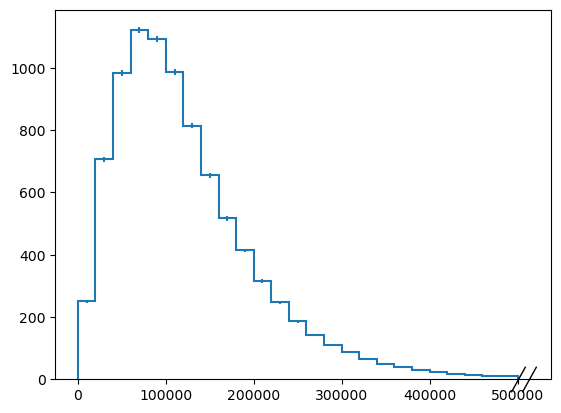

In [9]:
# Plot the 4-top MET before normalizing
hep.histplot(hist_weighted_dict["tttt"])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f35a5c85610>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

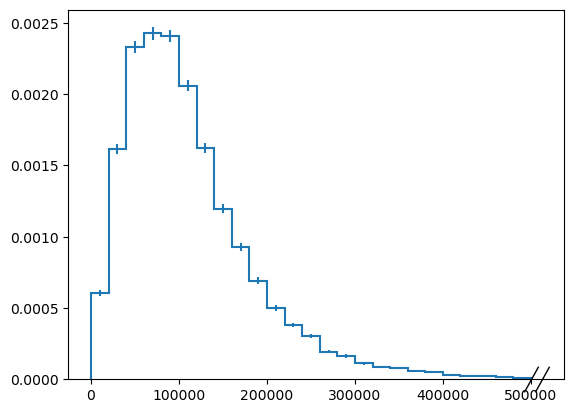

In [10]:
# Plot a resonance MET before normalizing
hep.histplot(hist_weighted_dict["ttZ-400"])

In [11]:
# Dictionaries for effective integrated luminosities and scale factors for each sample
lint_dict = {sample: None for sample in samples}
sf_dict = {sample: None for sample in samples}

In [12]:
# Work out the effective integrated luminosity for each sample
for sample in samples:
    lint_dict[sample] = sow_dict[sample]/cross_sections[sample]

In [13]:
# Define the integrated luminosity that we want to normalize to
lint = 140.1*invfb

In [14]:
# Work out the scale factors to normalize all samples to the same assumed luminosity
for sample in samples:
    sf_dict[sample] = lint/lint_dict[sample]

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f35a506eed0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

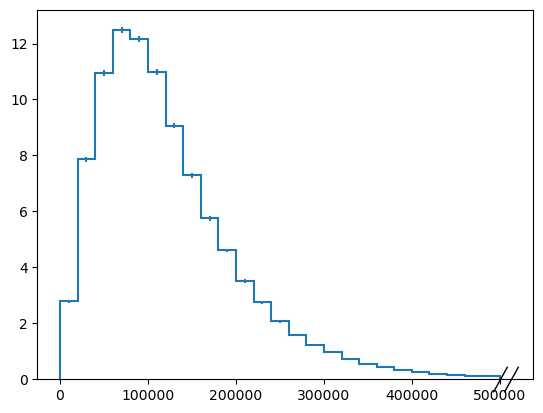

In [15]:
# Plot the normalised 4-top MET
hep.histplot(hist_weighted_dict["tttt"]*sf_dict["tttt"])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f35a4b78710>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

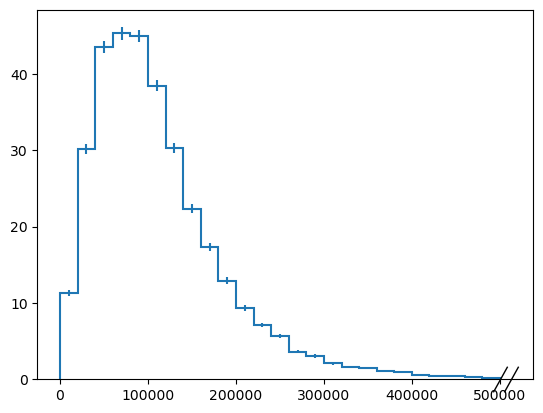

In [16]:
# Plot a normalized resonance MET
hep.histplot(hist_weighted_dict["ttZ-400"]*sf_dict["ttZ-400"])

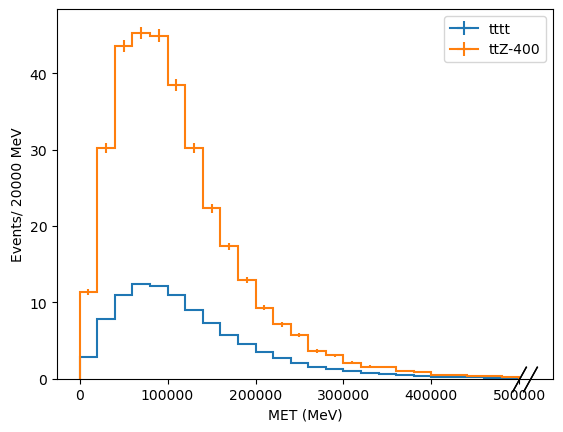

In [17]:
# Compare the 4-top MET with one of the resonance MET, normalising both distributions to the same assumed integrated luminosity
fig, ax = plt.subplots()
hep.histplot(hist_weighted_dict["tttt"]*sf_dict["tttt"], label="tttt")
sample = "ttZ-400"
hep.histplot(hist_weighted_dict[sample]*sf_dict[sample], label=sample)
ax.set_xlabel("MET (MeV)", fontsize=10)
ax.set_ylabel("Events/ 20000 MeV", fontsize=10)
ax.legend()
plt.show()

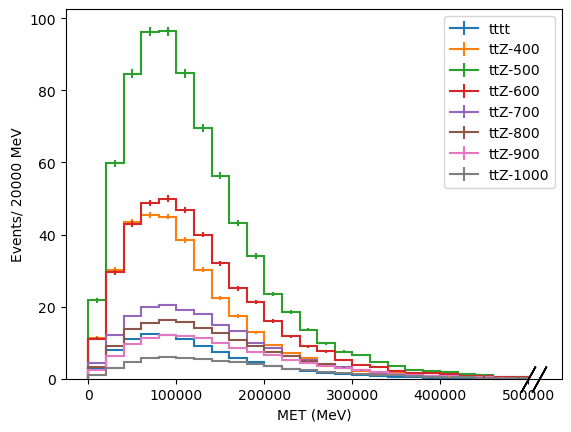

In [18]:
# Compare the MET for the 4-top and all resonance sample MET, all normalized
fig, ax = plt.subplots()
hep.histplot(hist_weighted_dict["tttt"]*sf_dict["tttt"], label="tttt")
for sample in [ "ttZ-400", "ttZ-500", "ttZ-600", "ttZ-700", "ttZ-800", "ttZ-900", "ttZ-1000" ]:
    hep.histplot(hist_weighted_dict[sample]*sf_dict[sample], label=sample)
ax.set_xlabel("MET (MeV)", fontsize=10)
ax.set_ylabel("Events/ 20000 MeV", fontsize=10)
ax.legend()
plt.show()

In [19]:
# Construct a  table of event numbers etc for each sample
print("Sample          Cross-section        Events unweighted        Sum of weights         Lint (fb-1)         Scale Factor               Sum of weights       Predicted events")
print("                     (nb)           (downloaded ntups)     (downloaded ntups)    (downloaded ntups)     (to ",lint/invfb,"fb-1)         (downloaded ntups)        (",lint/invfb,"fb-1)")
print("                                     (from sumWeights)      (from sumWeights)           (effective)                                (from weight_mc)")
for sample in samples:
    print("{0:12}      {1:10.5e}              {2:10.0f}             {3:10.3f}            {4:10.4f}          {5:10.5e}                 {6:10.3f}   {7:18.1f}".format(sample, 
                                                                                                                                             cross_sections[sample]/nb, 
                                                                                                                                             events_dict[sample], 
                                                                                                                                             sow_dict[sample], 
                                                                                                                                             lint_dict[sample]/invfb, 
                                                                                                                                             sf_dict[sample],
                                                                                                                                             hist_weighted_dict[sample].sum(flow=True).value,
                                                                                                                                             sow_dict[sample]*sf_dict[sample]))

Sample          Cross-section        Events unweighted        Sum of weights         Lint (fb-1)         Scale Factor               Sum of weights       Predicted events
                     (nb)           (downloaded ntups)     (downloaded ntups)    (downloaded ntups)     (to  140.1 fb-1)         (downloaded ntups)        ( 140.1 fb-1)
                                     (from sumWeights)      (from sumWeights)           (effective)                                (from weight_mc)
tttt              1.06650e-05                12595000             134287.471            12591.4178          1.11266e-02                   8927.795               1494.2
ttZ-400           2.97850e-05                  300000                  0.223                0.0075          1.86810e+04                      0.018               4172.9
ttZ-500           6.14160e-05                  510000                  0.783                0.0128          1.09882e+04                      0.068               8604.4
ttZ-600  

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f35a53b4350>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

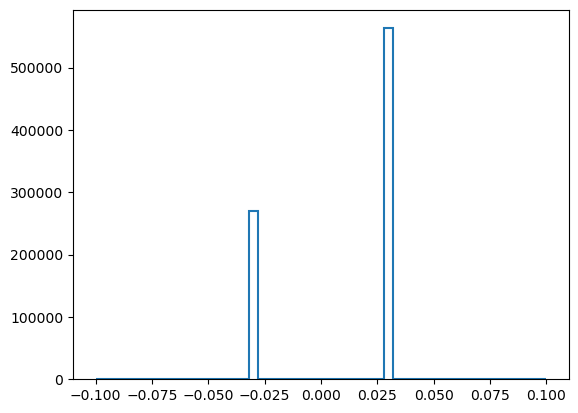

In [20]:
# An example of a weights lot - here for 4-top sample
hep.histplot(hist_weights_dict["tttt"])